# Digital Signals

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import IPython.display
matplotlib.rcParams['savefig.dpi'] = 144

**Signal Generator**

This function generates a signal using a trigonometric function:
- Amp: Amplitude of the signal. (Volts, Amperes, Watts, etc.)
- Phase: Phase of the signal at 0. (degrees)
- Frequency: Frequency of the signal or number of cycles per time unit. (hertz)
- Length: The number of complet periods of the signal to generate. (seconds)
- SR: Sampling rate, the number of samples per cycle we take of the signal. (# of samples/second)

In [2]:
def s_gen(amp=1.,phase=0.,freq=1,func=np.sin,length=1,sr=44100): 
    t = np.linspace(1/sr,length,sr*length)                       
    return amp*func(2*np.pi*(freq*t+phase/360))      

**Looking at the signals, sine and cosine with different attibutes**

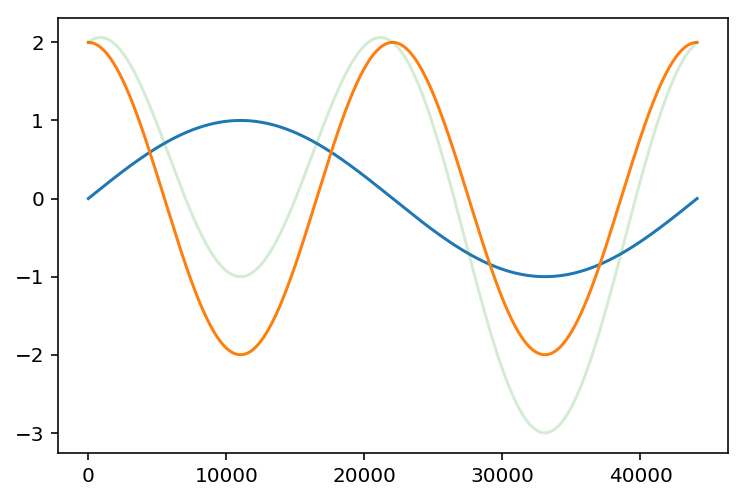

In [3]:
sin_x = s_gen()
cos_x = s_gen(amp=2,freq=2,func=np.cos)

plt.plot(sin_x)
plt.plot(cos_x)
plt.plot(sin_x+cos_x,alpha=0.2)
plt.show()

**Listening to the signals**

Generate signals within the human ear hearing range.

In [4]:
low_freq = s_gen(freq=40,length=3)
IPython.display.Audio(low_freq,rate=44100)

In [5]:
high_freq = s_gen(freq=16000,length=3)
IPython.display.Audio(high_freq,rate=44100)

**Check characteristics of the signals**

In [6]:
print('# of samples of low frequency signal {0}'.format(len(low_freq)))
print('Complete # of cycles of low frequency signal {0}'.format(40*len(high_freq)/44100))
print('Time length of low frequency signal {0} Hertz'.format(len(high_freq)/44100))
print('Period of low frequency signal {0} seconds'.format(1/40))

# of samples of low frequency signal 132300
Complete # of cycles of low frequency signal 120.0
Time length of low frequency signal 3.0 Hertz
Period of low frequency signal 0.025 seconds


**Spectrums**

This functions performs de Fast Fourier Transform of the samples of the signal provided, it then normalizes using the maximum value to scale down the rest and returns all the values that are above a certain threshold.
- x: The signal to analyse
- threshold: The threshold value from 0.0 to 1.0
- sr: The sampling rate

In [78]:
def s_fft(x,threshold=0.1,sr=44100):                                          
    result = pd.Series(abs(np.fft.fft(x)))
    length = len(result)
    result = result/result.max()
    result = result.ix[result>=threshold].ix[:int(len(result)/2)]
    result = result.sort_values(ascending=False)
    
    #if length > sr:
    result.index /= length/sr
    
    return result                                               

When we analyze an exact number of cycles everything is clean and nice.

For the high_freq signal, 16000 cycles in 1 second and 44100 samples per second.

In [79]:
s_fft(high_freq)

16000.0    1.0
dtype: float64

**Windowing**

If we don't analyse full cycles, frequency leakeage happens.

In [113]:
s_fft(high_freq[:42500])

16000.517647    1.000000
15999.480000    0.995411
16001.555294    0.332850
15998.442353    0.332284
16002.592941    0.199663
15997.404706    0.199418
16003.630588    0.142607
15996.367059    0.142451
16004.668235    0.110915
15995.329412    0.110796
dtype: float64

Most references to the Hanning, Hamming and Blackman windows come from the signal processing literature, where it is used as one of many windowing functions for smoothing values. It is also known as an apodization (which means “removing the foot”, i.e. smoothing discontinuities at the beginning and end of the sampled signal) or tapering function.

In [81]:
s_fft(high_freq[:42500]*np.blackman(42500))

16000.517647    1.000000
15999.480000    0.998844
16001.555294    0.334706
15998.442353    0.333361
dtype: float64

In [82]:
s_fft(high_freq[:42500]*np.hamming(42500))

16000.517647    1.000000
15999.480000    0.998134
16001.555294    0.138932
15998.442353    0.137768
dtype: float64

In [83]:
s_fft(high_freq[:42500]*np.hanning(42500))

16000.517647    1.000000
15999.480000    0.998489
16001.555294    0.200565
15998.442353    0.199175
dtype: float64

**Alias**

According to the Nyquist Rate, our sample rate should be > than frequency of the highest frequency we want to recover.

For a 22 kHz signal, the minimum sampling rate to recover it is 44 kHz (which happens to be the CD's sampling rate, or CD quality).

If we have a signal:
- freq = 10 kHz
- Sampling = 25 kHz

In [92]:
sr = 25e3
fr = 10e3
s_fft(s_gen(freq=fr,sr=sr),sr=sr)

10000.0    1.0
dtype: float64

But if we reduce the sampling rate or increase the frequency, alias occurs (and that's bad)

In [96]:
sr = 12e3
s_fft(s_gen(freq=fr,sr=sr),sr=sr)

2000.0    1.0
dtype: float64

In [97]:
sr = 25e3
fr = 42e3
s_fft(s_gen(freq=fr),sr=sr)

1190.47619    1.0
dtype: float64

Below is the frequency obtained by the FFT and a plot of the reconstructed signal, 20 cycles as expected from the FFT.

20.0    1.0
dtype: float64


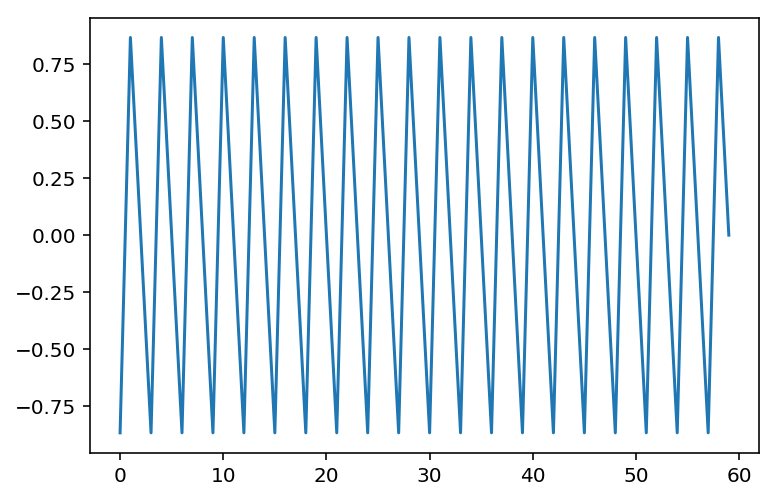

In [104]:
print(s_fft(s_gen(freq=100,sr=60),sr=60))
plt.plot(s_gen(freq=100,sr=60))
plt.show()

**Close frequencies**
What about close frequencies? Is it posible to differentiate really close ones?

In [65]:
s_fft(s_gen(freq=20000.5,length=1)+s_gen(freq=20000,length=1)) #The bucket size is bigger than the frequency

20000.0    1.000000
20001.0    0.537111
20002.0    0.179080
19999.0    0.178952
20003.0    0.107473
19998.0    0.107346
dtype: float64

In [66]:
s_fft(s_gen(freq=20000.5,length=2)+s_gen(freq=20000,length=2)) 

20000.5    1.0
20000.0    1.0
dtype: float64

**Zero padding**

Zero padding increases resolution by interpolation, when bins are not multiples of sampling frequency we might miss the exact frequencies.

The following function pads a signal with fron and back zeros (half & half) and up to the closest superior power of 2.

FFT consist of different algorithms that are efficient implementations of DFT (Discrete Fourier Transform). They have a O(nLogn) instead of O(n^2) and work better with power of 2 samples.

In [114]:
def padder(x,power=0):                                                
    pad   = int(2**np.ceil(np.log2(len(x))+power))           
    zeros = pad-len(x)                                       
    x   = np.pad(x,mode='constant',pad_width=int(zeros/2))   
    return x                                                 

Plot
- FFT
- FFT + Zero Padding (increasing resolution)
- FFT + Hamming Window (reducing frequency leakage)
- FFT + Hamming Window + Zero Padding

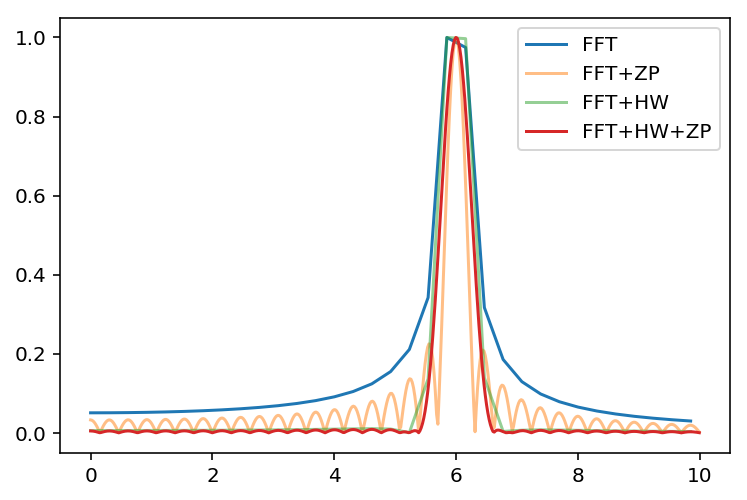

In [204]:
x = s_gen(freq=6,length=3.25)

plt.plot(s_fft(x,threshold=0).sort_index().ix[:10],alpha=1)
plt.plot(s_fft(padder(x,power=3),threshold=0).sort_index().ix[:10],alpha=0.5)
plt.plot(s_fft(np.hamming(143325)*x,threshold=0).sort_index().ix[:10],alpha=0.5)
plt.plot(s_fft(padder(np.hamming(int(44100*3.25))*x,power=3),threshold=0).sort_index().ix[:10],alpha=1)
plt.legend(['FFT','FFT+ZP','FFT+HW','FFT+HW+ZP'])
plt.show()

Spectrograms

Spectrograms are 2D heatmap plots, with the x axis being the time dimension and the y axis being the frequency dimension. 

- **Fs or Sampling frequency:** should be specified and should be the same used to record the the audio.
Human hearing range is from around 30 Hz to 20000 Hz. For cd audio quality a sampling rate of 44100 is used (twice the upper limit of the human range) this is due to Nyquist rate, which says that you should sample at least twice the highest frequency you want to recover (from analog to digital (recording) and digital to analog(playing)). If the sampling rate is inferior to the requested Nyquist frequency, the components that cannot be represented are folded, causing an erroneous spectral representation : this phenomenon is called "aliasing" or spectral folding.

- **NFFT:** Analysis of the signal for the spectrogram is done with a series of (typically overlaping) windows. By specifying the length of the windows we inccur in a tradeoff. A big windows will be able to include more frequencies (particularly lower ones) as it takes a bigger chunk of the signal to analyse (and allows for low frequencies to be included) but that gives us uncertainty on the exact position in time of those frequencies. The window specifies the number of samples to use. The lower the frequency, the larger the window needs to be (1/freq). WS = (Fs/freq)? [1](http://support.ircam.fr/docs/AudioSculpt/3.0/co/Window%20Size.html)

Sample Rate / Window Length = min frequency

- **STFT:** The method to transform a signal from the time domain to the frequency domain for the spectrogram is called the Fourier transform, in this case singe we are interested in the frequency content of a signal along time, chunks of the signal are analysed one by one.  Thus the Short time Fourier transform which is a Fast Fourier Transform for each chunk.

- **FFT:** Fast Fourier Transform is and optimized version of the DFT (Discrete Fourier Transform), whereas the DFT takes O(n^2) time, the FFT takes only O(nlog(n)). There are multiple versions of the FFT.



Knowledge of the type of frequencies expected can help to select those parameters. [2](https://stackoverflow.com/questions/29321696/what-is-a-spectrogram-and-how-do-i-set-its-parameters)

In [254]:
import librosa

In [256]:
rotv, sr = librosa.load('rotv.m4a',sr=44100)
IPython.display.Audio(rotv,rate=sr)

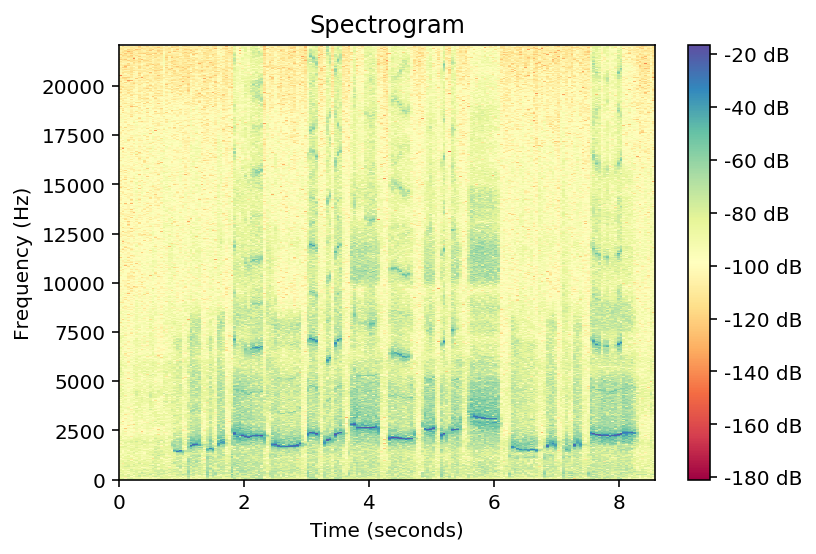

In [261]:
_ = plt.specgram(rotv,Fs=sr,NFFT=2048,cmap=plt.get_cmap('Spectral'),)
plt.colorbar(format='%+2.0f dB')
plt.ylim(0,22100)
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.show()

Compare both spectrograms. The one the windows are 256 and 2048 (or 256 * 8), the one with the bigger window offers better frequency definition, identifying more clearly the exact frequencies (while not being "as accurate" in the time department as the 256 window.)

The size of the window is also relevant to identify lower frequencies, the bigger the better lower frequencies (a bigger portion or an entire cycle of the signal can fit in the window.)

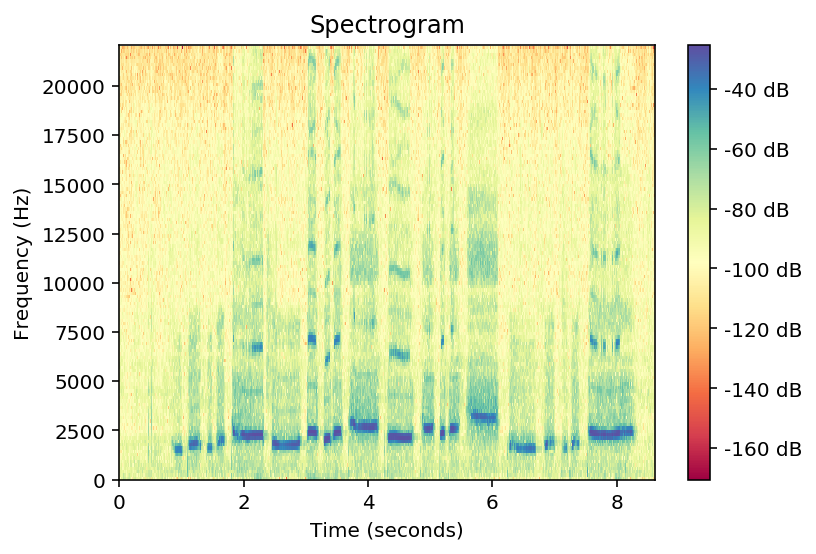

In [316]:
_ = plt.specgram(rotv,Fs=sr,NFFT=256,cmap=plt.get_cmap('Spectral'),)
plt.colorbar(format='%+2.0f dB')
plt.ylim(0,22100)
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.show()

**Voice dataset**

In [318]:
voice = pd.read_csv('voicegender.zip')

Data Description

- duration: length of signal
- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal
- maxfun: maximum fundamental frequency measured across acoustic signal
- meandom: average of dominant frequency measured across acoustic signal
- mindom: minimum of dominant frequency measured across acoustic signal
- maxdom: maximum of dominant frequency measured across acoustic signal
- dfrange: range of dominant frequency measured across acoustic signal
- modindx: modulation index. Calculated as the accumulated absolute difference between 

In [320]:
voice.shape

(3168, 21)

In [321]:
pd.set_option('display.max_columns',21)
voice.head(3)

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   

          kurt    sp.ent       sfm  mode  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918   0.0  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724   0.0  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905   0.0  0.077316  0.098706  0.015656   

     maxfun   meandom    mindom    maxdom   dfrange   modindx label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000  male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632  male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512  male

In [322]:
target = voice['label']
voice.drop('label',axis=1,inplace=True)

In [332]:
target.value_counts()

male      1584
female    1584
Name: label, dtype: int64

In [333]:
voice.isnull().sum().sum()

0

In [328]:
voice['meanfun'].ix[target=='male'].hist(alpha=0.5)
voice['meanfun'].ix[target=='female'].hist(alpha=0.5)
plt.show()

In [368]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(voice['meanfun'],target,train_size=0.6,random_state=0)

In [378]:
class normal_class(object):
    def __init__(self):
        pass
    
    def fit(self,X_train,y_train):
        self.mm = X_train.ix[target=='male'].mean()
        self.ms = X_train.ix[target=='male'].std()
        self.fm = X_train.ix[target=='female'].mean()
        self.fs = X_train.ix[target=='female'].std()
      
    def predict(self,X_test):         
        mc = abs((X_test-self.mm)/self.ms)
        fc = abs((X_test-self.fm)/self.fs)
        
        result = []
        for i,j in zip(mc,fc):     
            
            if i <= j:
                result.append('male')
            else:
                result.append('female')
        return result

In [380]:
clf = normal_class()
clf.fit(X_train,y_train)

In [359]:
from sklearn.metrics import confusion_matrix as CF

def cm_stats(cf):
    acc = 0.
    for i in range(cf.shape[0]):
        acc += cf[i][i]
    print('Accuracy: {0:.4f}'.format(acc/sum(sum(cf))))
    print('Precision: {0:.4f}'.format(cf[0][0]/(cf[0][0]+cf[1][0])))
    print('Recall: {0:.4f}'.format(cf[0][0]/(cf[0][0]+cf[0][1])))

In [383]:
cm_stats(CF(y_test,clf.predict(X_test)))

Accuracy: 0.9582
Precision: 0.9679
Recall: 0.9439


The error is the shadowed area in the histograms.

---

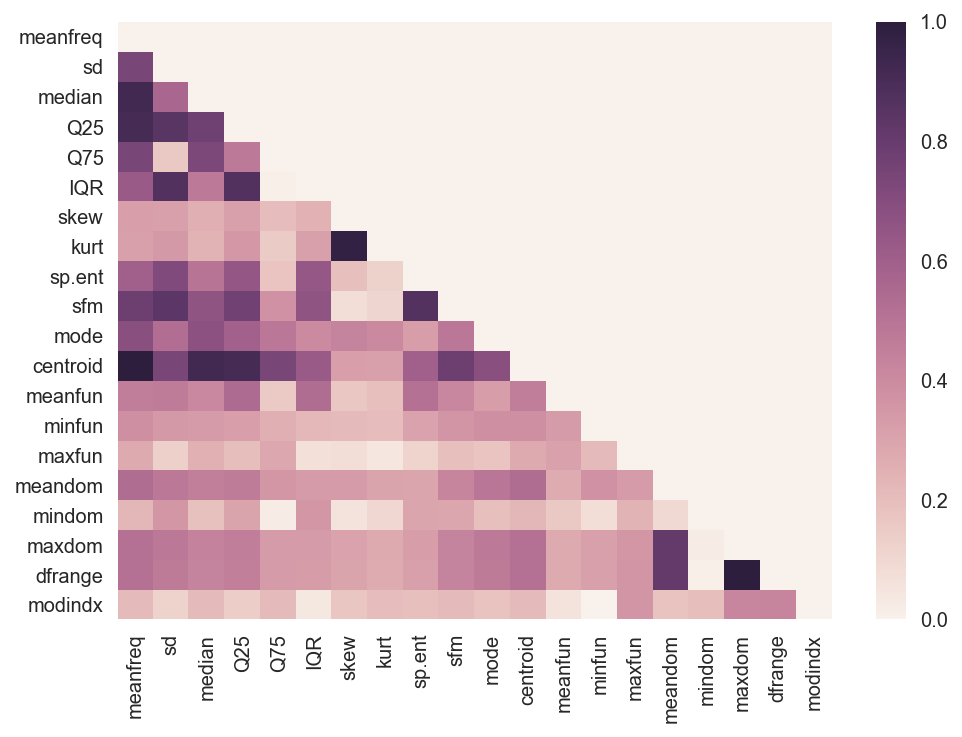

In [407]:
import seaborn as sns
corr = voice.corr()
sns.heatmap(np.tril(abs(corr), k=-1),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [434]:
corrs = []
for col in voice.columns:
    corrs.append([col,abs(np.corrcoef(voice[col],target.apply(lambda x: 1 if x == 'male' else 0))[0][1])])

In [439]:
pd.DataFrame(corrs).sort_values(1,ascending=False).head()

0         1
12  meanfun  0.833921
5       IQR  0.618916
3       Q25  0.511455
8    sp.ent  0.490552
1        sd  0.479539

---

**Filters**

Moving Average

In [474]:
x = s_gen(amp=2,freq=40) + np.random.normal(0,.4,44100)
plt.plot(x[:4410],alpha=0.5)
plt.plot(pd.rolling_mean(x,window=44)[:4410])
plt.show()

/Users/luiscastro/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


Exponential Weighted moving average

In [477]:
plt.plot(x[:4410],alpha=0.5)
plt.plot(pd.ewma(x,halflife=10)[:4410])
plt.show()

/Users/luiscastro/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


Butterworth filter

Flat pass band.

In [539]:
degree = 4
cutoff = 0.03125 # 1/sqrt(2) or -3 dB cutoff frequency, Wn is normalized from 0 to 1, where 1 is the Nyquist frequency
              # 44100 * 0.03125 = 1378
#cutoff = 0.0625

In [540]:
from scipy.signal import butter, lfilter

ts    = pd.Series(x[:4410]+s_gen(freq=1400,amp=2,length=0.1))

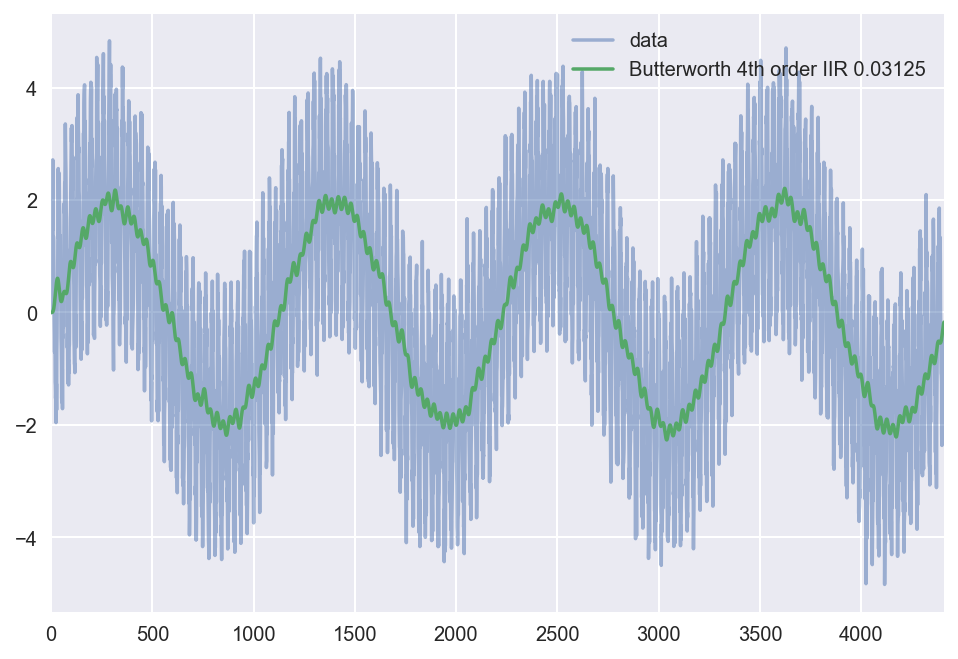

In [541]:
ts.plot(alpha=0.5)
pd.Series(data = lfilter(*butter(degree,cutoff, 'low'), x = ts.values),index = ts.index).plot(alpha = 1.0).plot()

plt.legend(['data','Butterworth '+str(degree)+'th order IIR '+str(cutoff)])

plt.show()